In [50]:
%matplotlib inline

import numpy as np
import rioxarray as rx
import cmaps as nclcmaps
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [51]:
def floodFill(c, r, mask):
    """
    Crawls a mask array containing only 1 and 0 values from the
    starting point (c=column, r=row - a.k.a. x, y) and returns
    an array with all 1 values connected to the starting cell.
    This algorithm performs a 4-way check non-recursively.
    """
    # cells already filled
    filled = set()
    # cells to fill
    fill = set()
    fill.add((c, r))
    width = mask.shape[1]-1
    height = mask.shape[0]-1
    # Our output inundation array
    flood = np.zeros_like(mask, dtype=np.int8)
    # Loop through and modify the cells which need to be checked.
    while fill:
        # Grab a cell
        x, y = fill.pop()
        if y == height or x == width or x < 0 or y < 0:
            # Don't fill
            continue
        if mask[y][x] == 1:
            # Do fill
            flood[y][x] = 1
            filled.add((x, y))
            # Check neighbors for 1 values
            west = (x-1, y)
            east = (x+1, y)
            north = (x, y-1)
            south = (x, y+1)
            if west not in filled:
                fill.add(west)
            if east not in filled:
                fill.add(east)
            if north not in filled:
                fill.add(north)
            if south not in filled:
                fill.add(south)
    return flood

In [52]:
infile = "DEMNAS_1016-53_v1.0.tif"
da_dem = rx.open_rasterio(infile).drop('band')[0]
da_dem = da_dem.where(da_dem>=-1, np.nan)

In [53]:
print(da_dem.min(), da_dem.max())

<xarray.DataArray 'z' ()>
array(-0.99995399)
Coordinates:
    spatial_ref  int32 0 <xarray.DataArray 'z' ()>
array(162.63819885)
Coordinates:
    spatial_ref  int32 0


In [54]:
sy, sx = np.unravel_index(da_dem.argmin(), da_dem.shape)

# set up 80m water depth just for demo
img = da_dem.values
a = np.where(img < 50, 1, 0)
print("Image masked")

print("Beginning flood fill")
fld = floodFill(sx, sy, a)
print("Finished Flood fill")

print('restore to dem')
where_0 = np.where(fld == 0)
where_1 = np.where(fld == 1)
fld[where_0] = 1
fld[where_1] = 0
da_flood = da_dem*fld

Image masked
Beginning flood fill
Finished Flood fill
restore to dem


(104.0, 104.25, 0.75, 1.0)

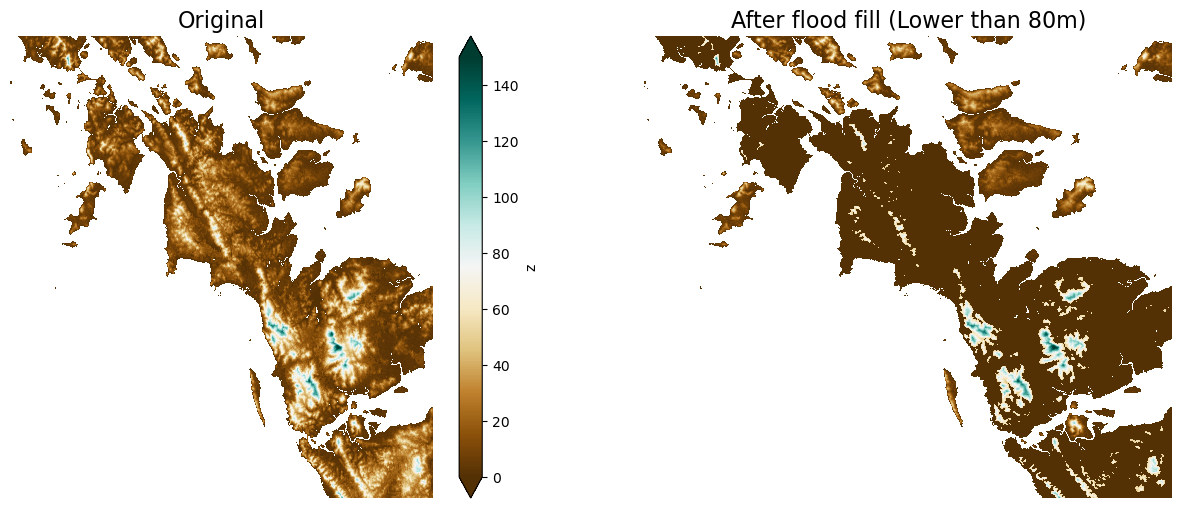

In [55]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 6))

da_dem.plot(ax=ax[0],
            cmap='BrBG',
            vmax=150, vmin=0, 
            add_colorbar=True
           )
ax[0].set_title('Original', fontsize=16)
ax[0].axis('off')

da_flood.plot(ax=ax[1],
              cmap='BrBG',
              vmax=150, vmin=0, 
              add_colorbar=False
             )
ax[1].set_title('After flood fill (Lower than 80m)', fontsize=16)
ax[1].axis('off')